In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf



In [ ]:
def get_stock_data_yfinance(symbol="MSFT", start="2018-01-01", end="2024-12-31"):
    data = yf.download(symbol, start=start, end=end)
    return data[['Close']]


data = get_stock_data_yfinance()
print(data.head())

plt.figure(figsize=(12, 6))
plt.plot(data, label="Close Price")
plt.title("MSFT Historical Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

window_size=60  
X, y = [], []


# 80% training, 20% testing
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare training data
X_train, y_train = [], []
for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i])  # Last 60 days for prediction
    y_train.append(train_data[i])  # Current day's closing price


X_train, y_train = np.array(X_train), np.array(y_train)


X_test, y_test = [], []
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i])  # Last 10 days for prediction
    y_test.append(test_data[i])  # Current day's closing price

X_test, y_test = np.array(X_test), np.array(y_test)


if X_train.shape[0] == 0 or X_test.shape[0] == 0:
    raise ValueError("No data available for training or testing.")



[*********************100%***********************]  1 of 1 completed


ValueError: too many values to unpack (expected 2)

In [13]:
input_shape = (X_train.shape[1], X_train.shape[2])  
    
model = tf.keras.Sequential([
        tf.keras.layers.LSTM(150, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(50),
        tf.keras.layers.Dense(1)
    ])
model.compile(optimizer='adam', loss='mse')
callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=1,callbacks=[callback])



test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")

predicted_scaled = model.predict(X_test)


predicted_prices = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0251 - val_loss: 0.0012
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 4.7373e-04 - val_loss: 0.0011
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 4.7011e-04 - val_loss: 0.0014
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 4.6933e-04 - val_loss: 0.0017
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 4.0156e-04 - val_loss: 7.3590e-04
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.3972e-04 - val_loss: 7.4041e-04
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 3.8308e-04 - val_loss: 6.8145e-04
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3.9332e-04 - val_loss: 7.7228e-04
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 4.4004e-04 - val_loss: 8.5884e-04
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 3.5678e-04 - val_loss: 0.0017
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.9272e-04 - val_loss:

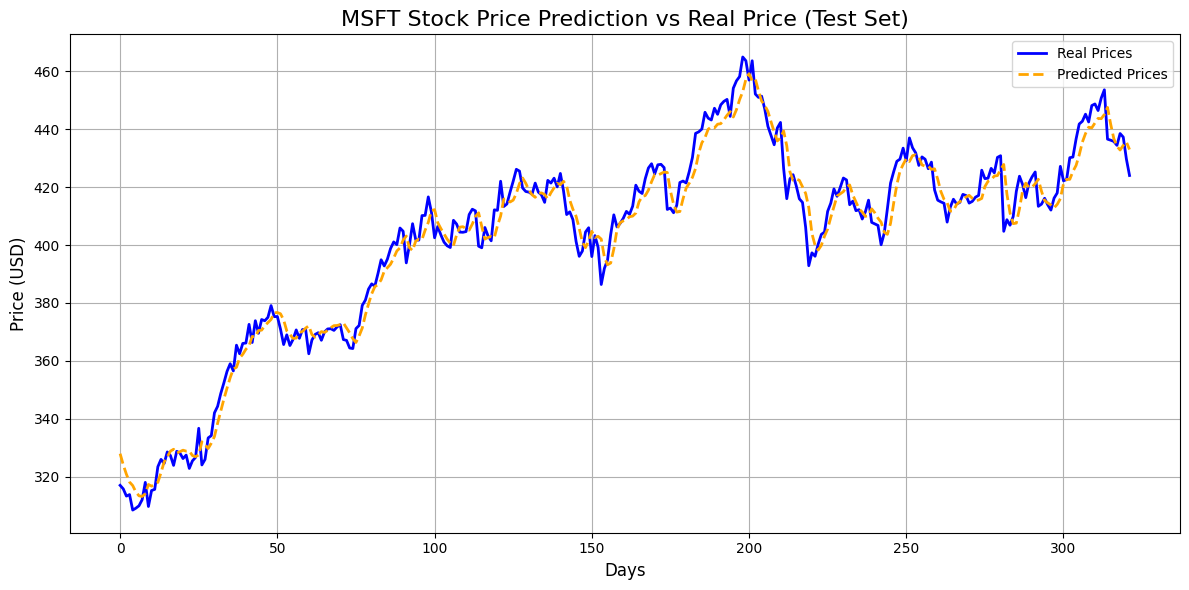

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(real_prices, label='Real Prices', color='blue', linewidth=2)
plt.plot(predicted_prices, label='Predicted Prices', color='orange', linestyle='--', linewidth=2)

plt.title("MSFT Stock Price Prediction vs Real Price (Test Set)", fontsize=16)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


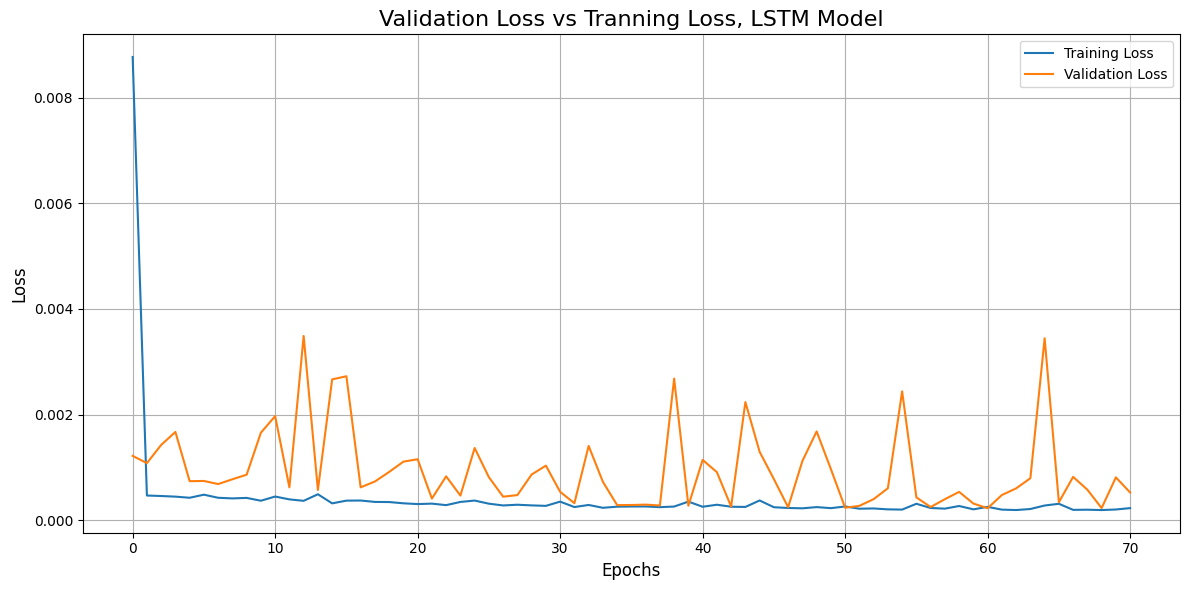

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Validation Loss vs Tranning Loss, LSTM Model", fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
